In [28]:
from data_parser import read_users, read_values_and_situations
from pairwise_comparison import PairwiseComparison
import numpy as np
import matplotlib.pyplot as plt

In [29]:
values, values_name_only, situation_list = read_values_and_situations("data/values.csv", "data/situations.csv")
users = read_users("data/results.csv")
for user in users:
    user.set_choices_responses()
    user.set_sliders_responses()

In [30]:
pcm_r_mean = np.zeros((len(values),len(values)))
pcm_p_mean = np.zeros((len(values),len(values)))
mean_sliders_responses = np.zeros(len(values))
total_differences = np.zeros(len(values))
errors = np.zeros(len(users))
sup_5 = np.zeros(len(users))
sup_10 = np.zeros(len(users))
mean_relevances = np.zeros(len(situation_list))

In [31]:
def process_user(user_number):
    w = np.zeros(len(situation_list))
    for i in range(len(situation_list)):
        w[i] = (0.5-0.4*users[user_number].difficulties[i])
    pcm = PairwiseComparison(values)
    pcm_r = pcm.get_raw(situation_list,users[user_number].choices)
    pcm_p = pcm.get_probability(situation_list, users[user_number].choices,w)
    eigenvalues_p, eigenvectors_p = np.linalg.eig(pcm_p)
    principal_eigenvector_p = np.abs(eigenvectors_p[:, 0])
    eigen_scores_p = principal_eigenvector_p / np.sum(principal_eigenvector_p)

    pairwise_vs_sliders = np.zeros(len(values))
    for i in range(len(values)):
        pairwise_vs_sliders[i] = users[user_number].sliders_responses[i] - eigen_scores_p[i] 
        mean_sliders_responses[i] += users[user_number].sliders_responses[i]
        total_differences[i] += np.abs(pairwise_vs_sliders[i])

    for i in range(len(situation_list)):
        mean_relevances[i] += users[user_number].choice_responses[i][3]

    for i in range(len(values)):
        for j in range(len(values)):
            pcm_r_mean[i][j] += pcm_r[i][j]
            pcm_p_mean[i][j] += pcm_p[i][j]

    errors[user_number] = np.sum(np.abs(pairwise_vs_sliders))

    nb_sup5 = 0
    nb_sup10 = 0
    for i in range(len(pairwise_vs_sliders)):
        if np.abs(pairwise_vs_sliders[i]) > 0.05 : nb_sup5 += 1
        if np.abs(pairwise_vs_sliders[i]) > 0.1 : nb_sup10 += 1

    sup_5[user_number] = nb_sup5
    sup_10[user_number] = nb_sup10

    print(values_name_only)
    print(pcm_r)
    print("############################")
    print(values_name_only)
    print(pcm_p)
    print("############################")
    ind = np.arange(len(values))
    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111)
    ax.bar(x=ind, height=users[user_number].sliders_responses, width=0.6,align='center', color="#0B31A5", label="Sliders responses")
    ax.bar(x=ind, height=eigen_scores_p, width=0.4,  align='center', color="#71AFE2", label="Eigen scores")
    ax.bar(x=ind, height=np.abs(pairwise_vs_sliders), width=0.2,  align='center', color="#B73A3A", label="Absolute difference")
    ax.set_ylim(0, 0.34)
    plt.xticks(ind, values_name_only)
    ax.set_title("Importance weight of each value")
    ax.set_xlabel("Values")
    ax.set_ylabel("Values weight")
    ax.legend()
    plt.show()

    print(f"Somme des erreurs : {errors[user_number]}")
    print(f"Nombre d'erreurs supérieures à 0.05 : {nb_sup5}")
    print(f"    dont supérieures à 0.1 : {nb_sup10}")
    
    
def process_global():
    mean_error = np.mean(errors)
    mean_sup_5 = np.mean(sup_5)
    mean_sup_10 = np.mean(sup_10)
    for i in range(len(values)):
        for j in range(len(values)):
            pcm_r_mean[i][j] /= len(users)
            pcm_p_mean[i][j] /= len(users)
    for i in range(len(values)):
        mean_sliders_responses[i] /= len(users)
        total_differences[i] /= len(users)
    for i in range(len(situation_list)):
        mean_relevances[i] /= len(users)
    eigenvalues_p_mean, eigenvectors_p_mean = np.linalg.eig(pcm_p_mean)
    principal_eigenvector_p_mean = np.abs(eigenvectors_p_mean[:, 0])
    eigen_scores_p_mean = principal_eigenvector_p_mean / np.sum(principal_eigenvector_p_mean)

    pairwise_vs_sliders_mean = np.zeros(len(values))
    for i in range(len(values)):
        pairwise_vs_sliders_mean[i] = mean_sliders_responses[i] - eigen_scores_p_mean[i]
    
    nb_sup5 = 0
    nb_sup10 = 0
    for i in range(len(pairwise_vs_sliders_mean)):
        if np.abs(pairwise_vs_sliders_mean[i]) > 0.05 : nb_sup5 += 1
        if np.abs(pairwise_vs_sliders_mean[i]) > 0.1 : nb_sup10 += 1

    pcm_pr_diff = np.zeros((len(values),len(values)))
    for i in range(len(values)):
        for j in range(len(values)):
            pcm_pr_diff[i][j] = pcm_r_mean[i][j] - pcm_p_mean[i][j]


    print(values_name_only)
    print(pcm_r_mean)
    print("############################")
    print(values_name_only)
    print(pcm_p_mean)
    print("############################")
    print(values_name_only)
    print(pcm_pr_diff)
    print("############################")
    ind = np.arange(len(values))
    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111)
    ax.bar(x=ind, height=mean_sliders_responses, width=0.6,align='center', color="#0B31A5", label="Sliders responses")
    ax.bar(x=ind, height=eigen_scores_p_mean, width=0.4,  align='center', color="#71AFE2", label="Eigen scores")
    ax.bar(values_name_only, total_differences, width=0.275, align='center', color="#750985", label="Mean differences")
    ax.bar(x=ind, height=np.abs(pairwise_vs_sliders_mean), width=0.2,  align='center', color="#B73A3A", label="Absolute difference")
    ax.set_ylim(0, 0.34)
    ax.set_xlabel("Values")
    ax.set_ylabel("Values weight")
    plt.xticks(ind, values_name_only)
    ax.set_title("Importance weight of each value")
    ax.legend()
    plt.show()
    print(f"Erreur globale du profil type : {np.sum(np.abs(pairwise_vs_sliders_mean))}")
    print(f"Erreur moyenne : {mean_error}")
    print(f"Nombre d'erreurs supérieures à 0.05 : {nb_sup5} (en moyenne {mean_sup_5})")
    print(f"    dont supérieures à 0.1 : {nb_sup10} (en moyenne {mean_sup_10})")
    

In [32]:
def choices_results():
    print(f"Pertinences moyennes : {mean_relevances}")
    ind = np.arange(len(situation_list))
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(111)
    ax.bar(ind, mean_relevances)
    ax.set_title("Mean relevance of each situation")

    option0_count = np.zeros(len(situation_list))
    option0_diffs = np.zeros(len(situation_list))
    option1_count = np.zeros(len(situation_list))
    option1_diffs = np.zeros(len(situation_list))

    for i in range(len(users)):
        for j in range(len(situation_list)):
            if users[i].choices[j] == 0 : 
                option0_count[j] += 1
                option0_diffs[j] += users[i].difficulties[j]
            if users[i].choices[j] == 1 : 
                option1_count[j] += 1
                option1_diffs[j] += users[i].difficulties[j]
    for j in range(len(situation_list)):
        option0_diffs[j] /= option0_count[j] #nb de votants pour cette option
        option0_count[j] /= len(users)
        option1_diffs[j] /= option1_count[j]
        option1_count[j] /= len(users)


    ind = np.arange(len(situation_list))
    width = np.min(np.diff(ind))/3
    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111)
    ax.bar(x=ind-width-0.05, height=option0_count, width=0.4,align='edge', color="#326633", label="First option")
    ax.bar(x=ind+0.01, height=option1_count, width=0.4,align='edge', color="#6B91C9", label="Second option")   
    ax.set_xlabel("Situation")
    ax.set_ylabel("Score")    
    ax.set_title("Choice for each situation")
    ax.scatter(ind, mean_relevances, color = "black", label="Mean relevance")
    ax.legend()
    plt.show()
    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111)
    ax.bar(x=ind-width-0.05, height=option0_diffs, width=0.4,align='edge', color="#478F48", label="Mean difficulty (first option chosen)")
    ax.bar(x=ind+0.01, height=option1_diffs, width=0.4,align='edge', color="#54B5FB", label="Mean difficulty (second option chosen)")   
    ax.set_xlabel("Situation")
    ax.set_ylabel("Score") 
    ax.set_title("Mean difficulty of decision for each situation")
    ax.scatter(ind, mean_relevances, color = "black", label="Mean relevance")
    ax.legend()
    plt.show()
    


In [33]:
#Ajouter calcul de consistance pour chaque user
#Lire l'article eigenvector

# Etude individuelle des utilisateurs

User number 0
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1.]
 [0. 1. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.3 0.7 0.9 0.9 0.2]
 [0.7 1.  0.8 0.3 0.2 0.6]
 [0.3 0.2 1.  0.3 0.2 0.3]
 [0.1 0.7 0.7 1.  0.7 0.8]
 [0.1 0.8 0.8 0.3 1.  0.3]
 [0.8 0.4 0.7 0.2 0.7 1. ]]
############################


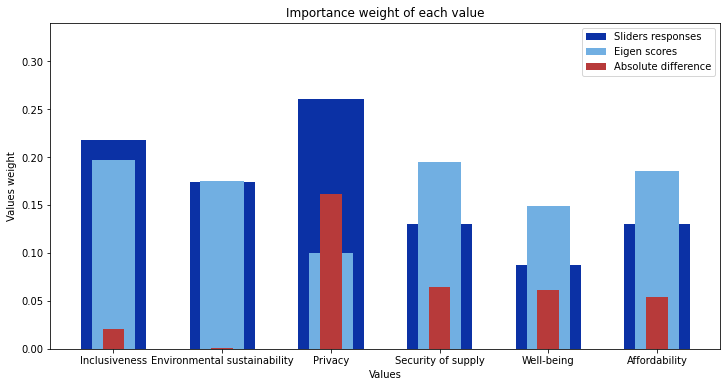

Somme des erreurs : 0.36329316514442356
Nombre d'erreurs supérieures à 0.05 : 4
    dont supérieures à 0.1 : 1

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 1
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 1. 1. 0. 1. 1.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [1. 1. 1. 1. 0. 1.]
 [0. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.7 0.8 0.3 0.6 0.6]
 [0.3 1.  0.9 0.1 0.2 0.3]
 [0.2 0.1 1.  0.2 0.1 1. ]
 [0.7 0.9 0.8 1.  0.2 0.8]
 [0.4 0.8 0.9 0.8 1.  0.9]
 [0.4 0.7 0.  0.2 0.1 1. ]]
############################


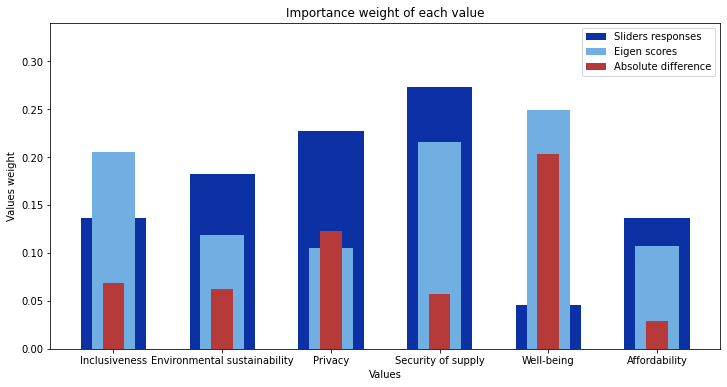

Somme des erreurs : 0.542525135013581
Nombre d'erreurs supérieures à 0.05 : 5
    dont supérieures à 0.1 : 2

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 2
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 1. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.8 0.9 0.9 0.9 0.7]
 [0.2 1.  0.9 1.  0.9 0.4]
 [0.1 0.1 1.  0.1 0.1 0.8]
 [0.1 0.  0.9 1.  1.  0.1]
 [0.1 0.1 0.9 0.  1.  0.1]
 [0.3 0.6 0.2 0.9 0.9 1. ]]
############################


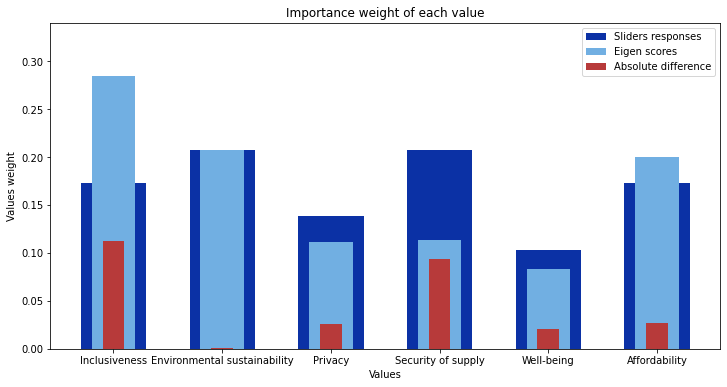

Somme des erreurs : 0.28090096833345846
Nombre d'erreurs supérieures à 0.05 : 2
    dont supérieures à 0.1 : 1

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 3
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 0. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 1.]
 [1. 0. 1. 1. 0. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.3 0.1 0.7 0.4 0.3]
 [0.7 1.  0.3 0.8 0.7 0.9]
 [0.9 0.7 1.  0.6 1.  0.1]
 [0.3 0.2 0.4 1.  0.7 0. ]
 [0.6 0.3 0.  0.3 1.  0.7]
 [0.7 0.1 0.9 1.  0.3 1. ]]
############################


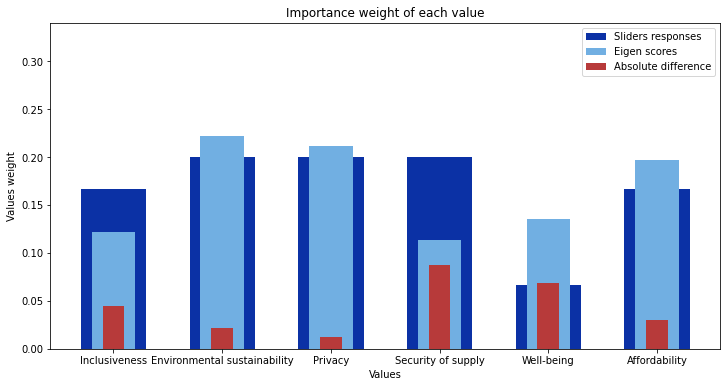

Somme des erreurs : 0.26380892291950764
Nombre d'erreurs supérieures à 0.05 : 2
    dont supérieures à 0.1 : 0

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 4
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.4 1.  1.  0.8 1. ]
 [0.6 1.  0.9 1.  0.9 0.7]
 [0.  0.1 1.  0.  0.1 0.6]
 [0.  0.  1.  1.  1.  0. ]
 [0.2 0.1 0.9 0.  1.  0. ]
 [0.  0.3 0.4 1.  1.  1. ]]
############################


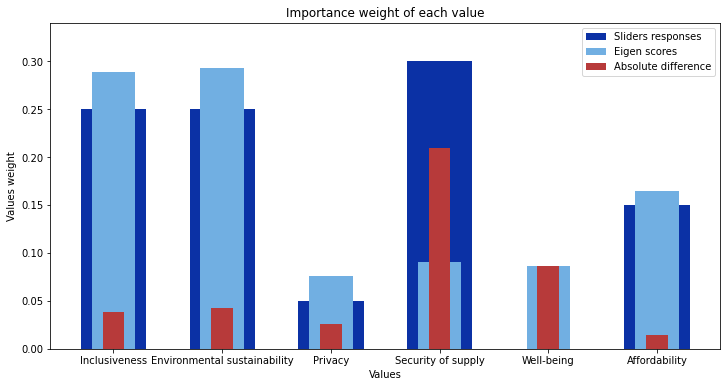

Somme des erreurs : 0.4185235184285515
Nombre d'erreurs supérieures à 0.05 : 2
    dont supérieures à 0.1 : 1

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 5
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.9 0.7 0.7 0.9 0.7]
 [0.1 1.  0.7 1.  0.7 0.3]
 [0.3 0.3 1.  0.4 0.4 0.6]
 [0.3 0.  0.6 1.  0.9 0.8]
 [0.1 0.3 0.6 0.1 1.  0. ]
 [0.3 0.7 0.4 0.2 1.  1. ]]
############################


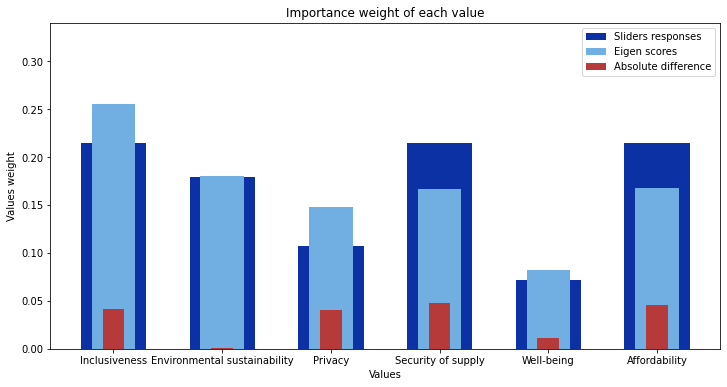

Somme des erreurs : 0.18772934612199196
Nombre d'erreurs supérieures à 0.05 : 0
    dont supérieures à 0.1 : 0

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 6
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 1. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.7 0.9 1.  0.6 0.9]
 [0.3 1.  0.9 0.3 0.7 0.3]
 [0.1 0.1 1.  0.1 0.1 0.9]
 [0.  0.7 0.9 1.  0.9 0.2]
 [0.4 0.3 0.9 0.1 1.  0.1]
 [0.1 0.7 0.1 0.8 0.9 1. ]]
############################


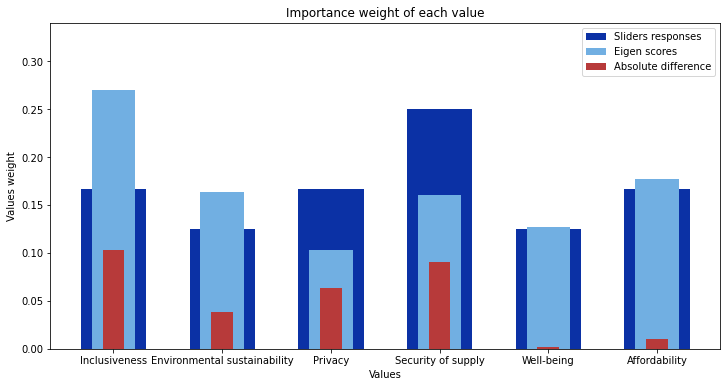

Somme des erreurs : 0.3065322734644305
Nombre d'erreurs supérieures à 0.05 : 3
    dont supérieures à 0.1 : 1

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 7
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 1.]
 [1. 1. 1. 0. 1. 0.]
 [0. 1. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 0.]
 [1. 0. 1. 1. 1. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.4 0.4 0.8 0.3 0.1]
 [0.6 1.  0.3 0.  0.3 0.7]
 [0.6 0.7 1.  0.4 0.7 0.1]
 [0.2 1.  0.6 1.  1.  0.1]
 [0.7 0.7 0.3 0.  1.  0.1]
 [0.9 0.3 0.9 0.9 0.9 1. ]]
############################


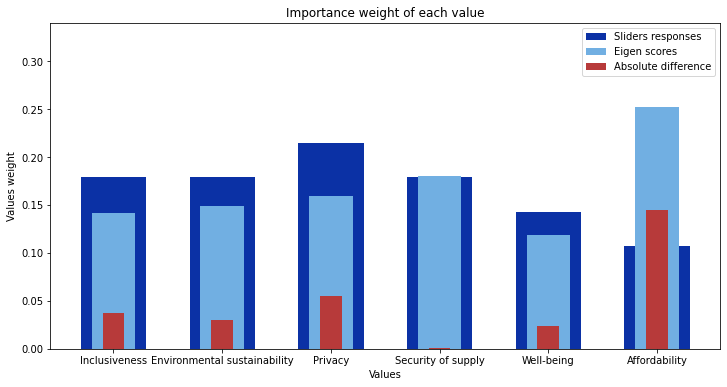

Somme des erreurs : 0.29184510226986377
Nombre d'erreurs supérieures à 0.05 : 2
    dont supérieures à 0.1 : 1

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 8
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.8 1.  0.9 0.8 1. ]
 [0.2 1.  1.  0.9 0.9 1. ]
 [0.  0.  1.  0.  0.  1. ]
 [0.1 0.1 1.  1.  1.  0.1]
 [0.2 0.1 1.  0.  1.  0.1]
 [0.  0.  0.  0.9 0.9 1. ]]
############################


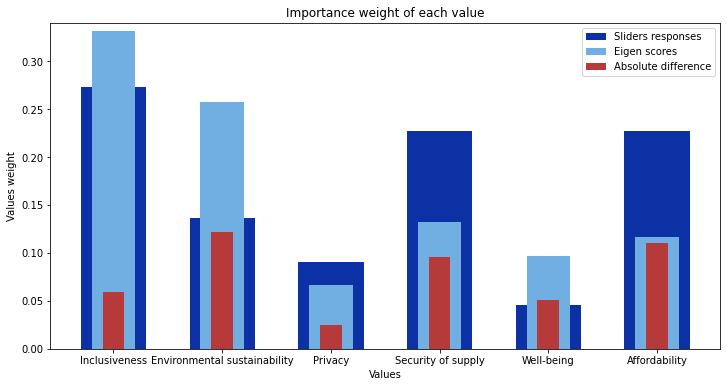

Somme des erreurs : 0.4616258762922191
Nombre d'erreurs supérieures à 0.05 : 5
    dont supérieures à 0.1 : 2

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 9
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1.]
 [1. 1. 0. 0. 0. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.8 0.9 0.8 0.2 0.2]
 [0.2 1.  0.9 0.9 0.1 0.2]
 [0.1 0.1 1.  0.1 0.1 1. ]
 [0.2 0.1 0.9 1.  0.9 0.8]
 [0.8 0.9 0.9 0.1 1.  0.9]
 [0.8 0.8 0.  0.2 0.1 1. ]]
############################


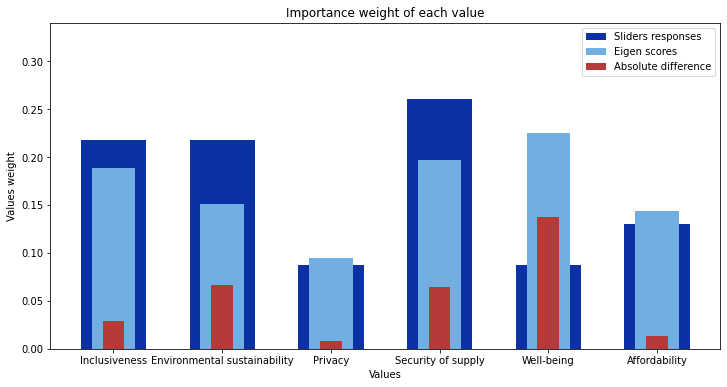

Somme des erreurs : 0.3184919353602875
Nombre d'erreurs supérieures à 0.05 : 3
    dont supérieures à 0.1 : 1

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 10
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 1. 1. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.8 1.  1.  0.1 1. ]
 [0.2 1.  1.  1.  0.  0.8]
 [0.  0.  1.  0.  0.  1. ]
 [0.  0.  1.  1.  1.  0. ]
 [0.9 1.  1.  0.  1.  0. ]
 [0.  0.2 0.  1.  1.  1. ]]
############################


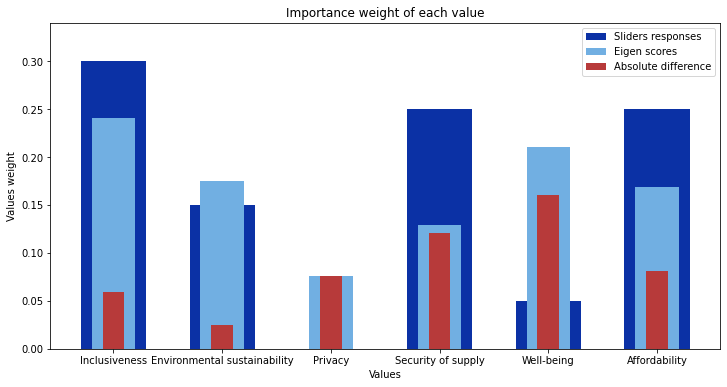

Somme des erreurs : 0.5228009955622567
Nombre d'erreurs supérieures à 0.05 : 5
    dont supérieures à 0.1 : 2

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 11
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.6 0.8 0.8 0.8 0.8]
 [0.4 1.  0.8 0.8 0.8 0.8]
 [0.2 0.2 1.  0.2 0.3 0.7]
 [0.2 0.2 0.8 1.  0.8 0.2]
 [0.2 0.2 0.7 0.2 1.  0.2]
 [0.2 0.2 0.3 0.8 0.8 1. ]]
############################


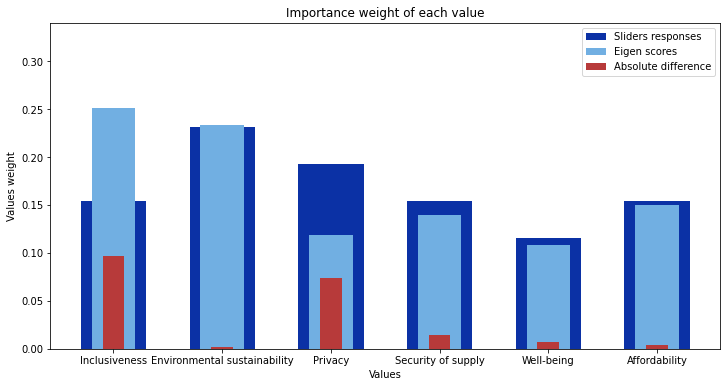

Somme des erreurs : 0.19803782316585578
Nombre d'erreurs supérieures à 0.05 : 2
    dont supérieures à 0.1 : 0

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 12
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.3 0.9 1.  0.9 0.7]
 [0.7 1.  0.9 1.  1.  1. ]
 [0.1 0.1 1.  0.1 0.  0.9]
 [0.  0.  0.9 1.  1.  0. ]
 [0.1 0.  1.  0.  1.  0.2]
 [0.3 0.  0.1 1.  0.8 1. ]]
############################


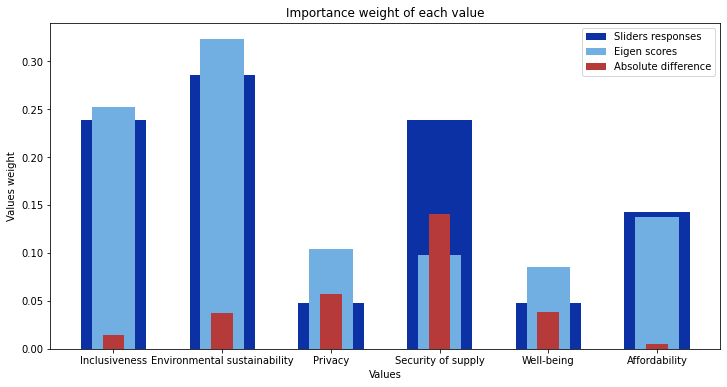

Somme des erreurs : 0.2907752035263629
Nombre d'erreurs supérieures à 0.05 : 2
    dont supérieures à 0.1 : 1

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 13
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 1.]
 [1. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 1. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.4 1.  0.3 0.9 0.3]
 [0.6 1.  1.  1.  0.9 0.7]
 [0.  0.  1.  0.  0.  0.9]
 [0.7 0.  1.  1.  1.  0.2]
 [0.1 0.1 1.  0.  1.  0. ]
 [0.7 0.3 0.1 0.8 1.  1. ]]
############################


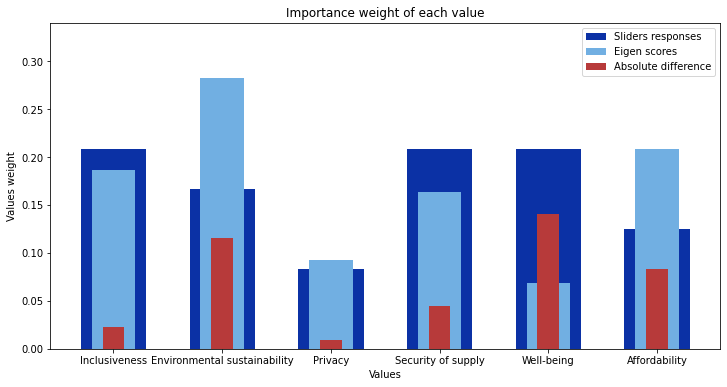

Somme des erreurs : 0.4149381415356851
Nombre d'erreurs supérieures à 0.05 : 3
    dont supérieures à 0.1 : 2

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
##########################################################################
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

User number 14
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0.]
 [0. 1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1.]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.  0.9 0.8 0.9 0.6 0.3]
 [0.1 1.  0.7 0.2 0.2 0.2]
 [0.2 0.3 1.  0.6 0.4 0.4]
 [0.1 0.8 0.4 1.  0.9 0.3]
 [0.4 0.8 0.6 0.1 1.  0. ]
 [0.7 0.8 0.6 0.7 1.  1. ]]
############################


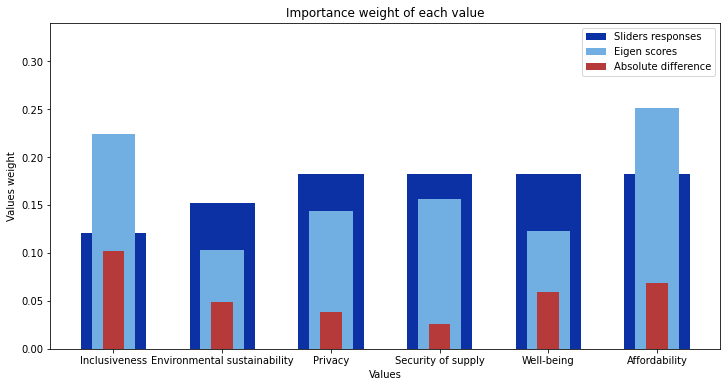

Somme des erreurs : 0.34242851575078237
Nombre d'erreurs supérieures à 0.05 : 3
    dont supérieures à 0.1 : 1


In [34]:
for i in range(len(users)):
    print(f"User number {i}")
    process_user(i)
    if i < len(users) - 1:
        print("")
        print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
        print("##########################################################################")
        print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
        print("")

# Profil type

['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.         0.6        0.86666667 0.86666667 0.73333333 0.6       ]
 [0.4        1.         0.86666667 0.66666667 0.6        0.6       ]
 [0.13333333 0.13333333 1.         0.13333333 0.13333333 0.73333333]
 [0.13333333 0.33333333 0.86666667 1.         0.93333333 0.26666667]
 [0.26666667 0.4        0.86666667 0.06666667 1.         0.2       ]
 [0.4        0.4        0.26666667 0.73333333 0.8        1.        ]]
############################
['Inclusiveness', 'Environmental sustainability', 'Privacy', 'Security of supply', 'Well-being', 'Affordability']
[[1.         0.60666667 0.79333333 0.8        0.64666667 0.58666667]
 [0.39333333 1.         0.8        0.68666667 0.56666667 0.59333333]
 [0.20666667 0.2        1.         0.20666667 0.23333333 0.68666667]
 [0.2        0.31333333 0.79333333 1.         0.86666667 0.29333333]
 [0.35333333 0.43333333 0.76666667 0.13333333 1.    

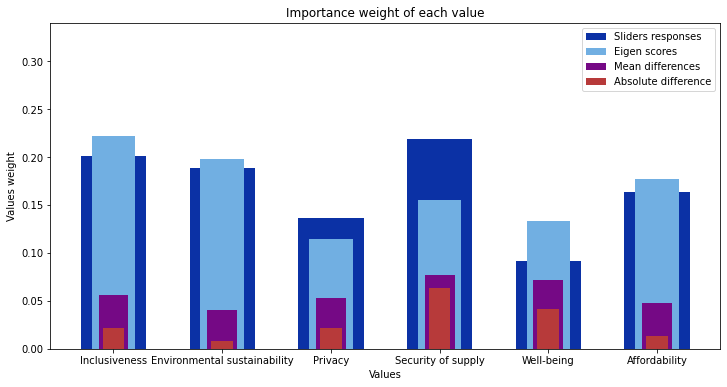

Erreur globale du profil type : 0.17100274183038017
Erreur moyenne : 0.3469504615259505
Nombre d'erreurs supérieures à 0.05 : 1 (en moyenne 2.8666666666666667)
    dont supérieures à 0.1 : 0 (en moyenne 1.0666666666666667)


In [35]:
process_global()

# Analyse des situations

Pertinences moyennes : [0.53333333 0.76666667 0.65       0.75       0.61666667 0.7
 0.63333333 0.5        0.63333333 0.56666667 0.75       0.73333333
 0.56666667 0.68333333 0.63333333]


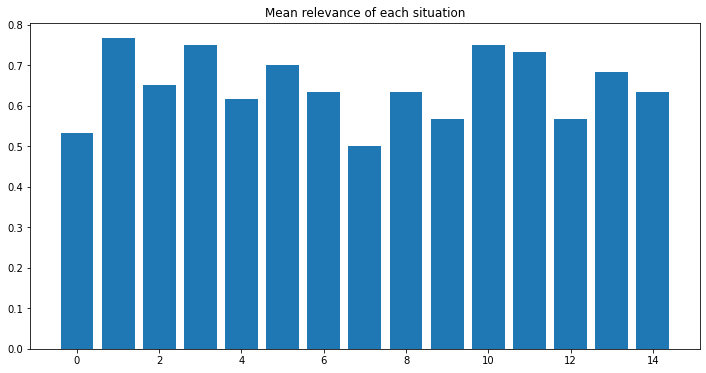

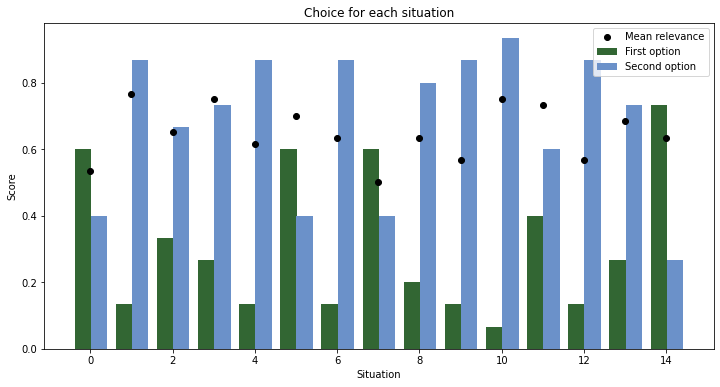

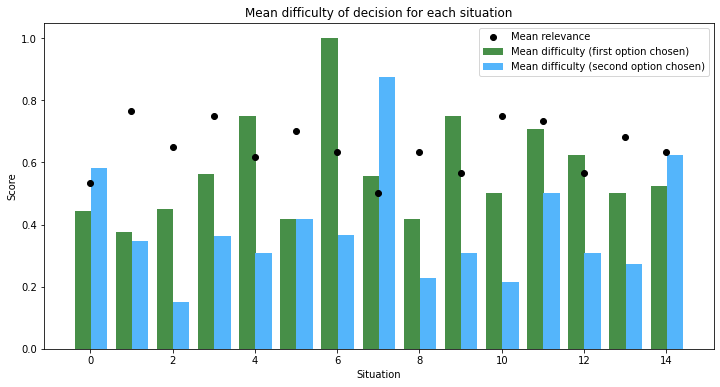

In [36]:
choices_results()